In [69]:
import pandas as pd

#df = pd.read_csv("data/2021_to_2024_pre_election/all_votes.csv")
df = pd.read_csv("data/post_2024_06_09/all_votes.csv")

# Identify vote columns (everything after metadata)
meta_cols = [
    "member.id", "member.first_name", "member.last_name",
    "member.country.code", "member.country.label",
    "member.country.iso_alpha_2",
    "member.group.code", "member.group.label", "member.group.short_label"
]
vote_cols = [c for c in df.columns if c not in meta_cols]

# Reshape to long format
votes_long = df.melt(
    id_vars=meta_cols,
    value_vars=vote_cols,
    var_name="vote_id",
    value_name="vote"
)

# (Optional) ensure numeric vote_id order
votes_long["vote_id"] = votes_long["vote_id"].astype(int)
votes_long = votes_long.sort_values("vote_id")

In [70]:
import pandas as pd
import numpy as np
from itertools import combinations

# Make sure vote_id is numeric
votes_long["vote_id"] = pd.to_numeric(votes_long["vote_id"], errors="coerce")
votes_long = votes_long.dropna(subset=["vote_id"])

# Create period groups (e.g. every 500 votes)
votes_long["period"] = (votes_long["vote_id"] // 100) * 500

results = []

for period, sub in votes_long.groupby("period"):
    # Aggregate: majority vote per group per vote_id
    agg = (sub.groupby(["vote_id", "member.group.short_label"])["vote"]
              .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
              .reset_index())

    # Pivot: one row per vote_id, one column per party
    pivot = agg.pivot(index="vote_id", columns="member.group.short_label", values="vote")

    # Compute pairwise agreements
    for g1, g2 in combinations(pivot.columns, 2):
        valid = pivot[[g1, g2]].dropna()
        if len(valid) == 0:
            continue
        agreement = (valid[g1] == valid[g2]).mean()
        results.append({"period": period, "g1": g1, "g2": g2, "agreement": agreement})

agreements = pd.DataFrame(results)

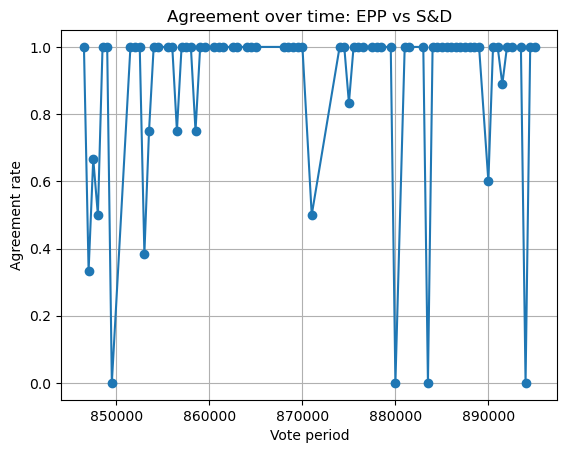

In [71]:
import matplotlib.pyplot as plt

pair = ("EPP", "S&D")
subset = agreements[(agreements["g1"] == pair[0]) & (agreements["g2"] == pair[1])]
plt.plot(subset["period"], subset["agreement"], marker="o")
plt.title(f"Agreement over time: {pair[0]} vs {pair[1]}")
plt.xlabel("Vote period")
plt.ylabel("Agreement rate")
plt.grid(True)
plt.show()

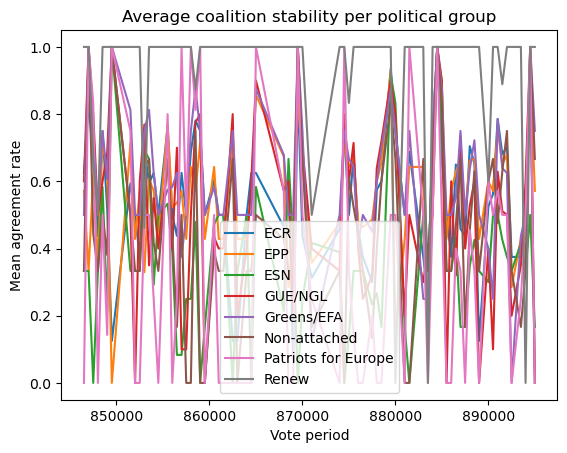

In [72]:
group_trends = agreements.groupby(["period", "g1"])["agreement"].mean().reset_index()
for g in group_trends["g1"].unique():
    plt.plot(group_trends[group_trends["g1"] == g]["period"],
             group_trends[group_trends["g1"] == g]["agreement"], label=g)

plt.title("Average coalition stability per political group")
plt.xlabel("Vote period")
plt.ylabel("Mean agreement rate")
plt.legend()
plt.show()

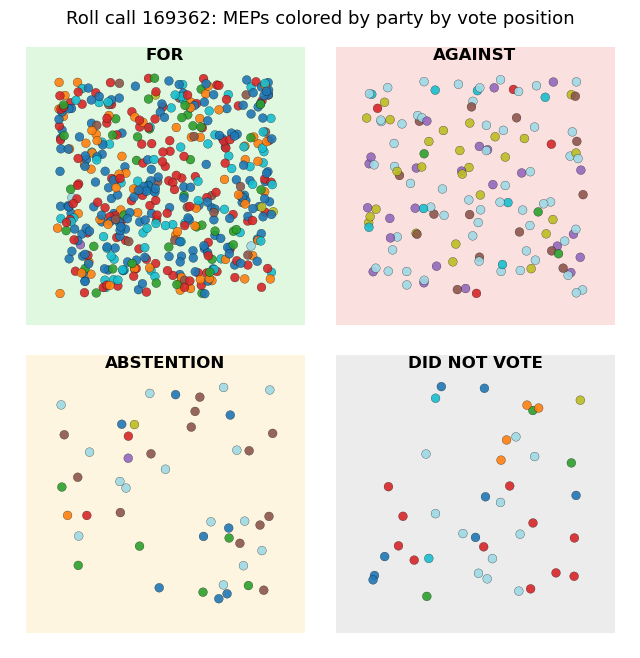

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pick one vote
vote_id = 169362
sub = votes_long[votes_long["vote_id"] == vote_id]

# colors for parties
party_palette = {
    "EPP": "#1f77b4",
    "S&D": "#d62728",
    "Renew": "#ff7f0e",
    "Greens/EFA": "#2ca02c",
    "ECR": "#17becf",
    "GUE/NGL": "#8c564b",
    "ESN": "#9467bd",
    "PFE": "#7f7f7f",
    "Non-attached": "#bcbd22",
}
default_color = "#9edae5"

# define positions for each zone
zones = {
    "FOR": (-1, 1),
    "AGAINST": (1, 1),
    "ABSTENTION": (-1, -1),
    "DID_NOT_VOTE": (1, -1),
}

# create figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_axis_off()

# background rectangles
zone_colors = {
    "FOR": (0.2, 0.8, 0.2, 0.15),
    "AGAINST": (0.9, 0.2, 0.2, 0.15),
    "ABSTENTION": (0.95, 0.75, 0.2, 0.15),
    "DID_NOT_VOTE": (0.4, 0.4, 0.4, 0.12),
}
for vote_type, (x, y) in zones.items():
    rect = plt.Rectangle((x - 0.9, y - 0.9), 1.8, 1.8,
                         facecolor=zone_colors[vote_type],
                         edgecolor="none")
    ax.add_patch(rect)
    ax.text(x, y + 0.8, vote_type.replace("_", " "),
            ha="center", va="bottom", fontsize=12, weight="bold")

# scatter dots in each zone
np.random.seed(0)
for vote_type, (x, y) in zones.items():
    voters = sub[sub["vote"] == vote_type]
    n = len(voters)
    if n == 0:
        continue

    # random scatter within the zone
    xs = x + np.random.uniform(-0.7, 0.7, n)
    ys = y + np.random.uniform(-0.7, 0.7, n)

    colors = [
        party_palette.get(p, default_color)
        for p in voters["member.group.short_label"]
    ]
    ax.scatter(xs, ys, c=colors, s=40, edgecolors="k", linewidths=0.2, alpha=0.9)

plt.title(f"Roll call {vote_id}: MEPs colored by party by vote position", fontsize=13)
plt.show()

/Users/nicolalorusso/miniconda3/lib/python3.10/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


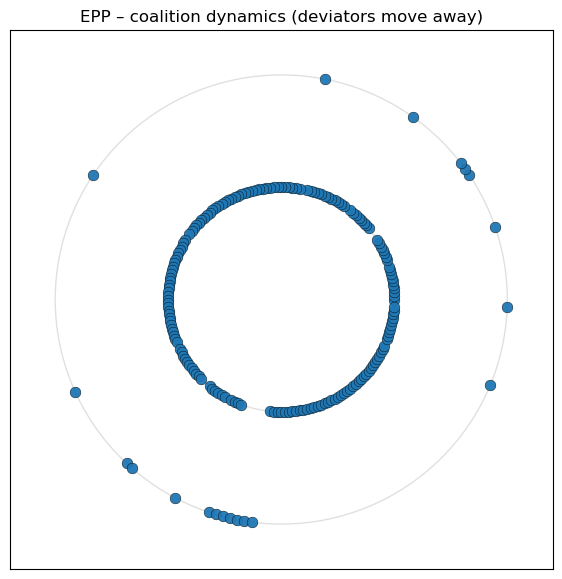

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# -------------------------
# CONFIG
# -------------------------
PARTY = "EPP"                  # party to animate
steps_per_vote = 12            # smoothness between roll calls
r_core = 0.25                  # radius for loyal members (cluster)
r_dev  = 0.5                   # radius for deviators (farther away)
dot_size = 60

party_palette = {
    "EPP": "#1f77b4", "S&D": "#d62728", "Renew": "#ff7f0e", "Greens/EFA": "#2ca02c",
    "ECR": "#17becf", "GUE/NGL": "#8c564b", "ESN": "#9467bd", "PFE": "#7f7f7f",
    "Non-attached": "#bcbd22",
}
color_party = party_palette.get(PARTY, "#9edae5")
vote_order = ["FOR","AGAINST","ABSTENTION","DID_NOT_VOTE"]  # tie-break order

# -------------------------
# DATA (expects votes_long with columns: vote_id, member.id, member.group.short_label, vote)
# -------------------------
df = votes_long.copy()
df["vote_id"] = pd.to_numeric(df["vote_id"], errors="coerce")
df = df.dropna(subset=["vote_id"])
df["vote_id"] = df["vote_id"].astype(int)

dfp = df[df["member.group.short_label"] == PARTY].copy()
valid_votes = set(vote_order)
dfp = dfp[dfp["vote"].isin(valid_votes)]
assert not dfp.empty, f"No rows for {PARTY}"

mep_ids = np.array(sorted(dfp["member.id"].unique()))
rollcalls = np.array(sorted(dfp["vote_id"].unique()))

# lookup vote per (mep, vote_id)
vote_lookup = {(int(r.member_id), int(r.vote_id)): r.vote
               for r in dfp.rename(columns={"member.id":"member_id"}).itertuples()}

# majority per rollcall (mode; deterministic tie-break)
majority = {}
for vid in rollcalls:
    votes = [vote_lookup[(mid, vid)] for mid in mep_ids if (mid, vid) in vote_lookup]
    if not votes:
        continue
    vc = pd.Series(votes).value_counts()
    top = vc[vc == vc.max()].index.tolist()
    top.sort(key=lambda v: vote_order.index(v))
    majority[vid] = top[0]

# -------------------------
# POSITIONS
# -------------------------
# fixed angle for each MEP so their direction is consistent across frames
angles = np.linspace(0, 2*np.pi, len(mep_ids), endpoint=False)
unit = np.c_[np.cos(angles), np.sin(angles)]

# target positions for each roll call
targets = []        # list of (n_mep, 2)
dev_masks = []      # list of (n_mep,) booleans
for vid in rollcalls:
    maj = majority.get(vid, None)
    XY = np.zeros((len(mep_ids), 2))
    dev = np.zeros(len(mep_ids), dtype=bool)
    for i, mid in enumerate(mep_ids):
        v = vote_lookup.get((mid, vid))
        if v is None:
            # treat as deviation if no recorded vote
            dev[i] = True
        else:
            dev[i] = (maj is not None) and (v != maj)
        # loyal stay near center, deviators go outwards along their personal angle
        radius = r_dev if dev[i] else r_core
        XY[i] = unit[i] * radius
    targets.append(XY)
    dev_masks.append(dev)

# -------------------------
# ANIMATION
# -------------------------
fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(-1.2*r_dev, 1.2*r_dev)
ax.set_ylim(-1.2*r_dev, 1.2*r_dev)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title(f"{PARTY} – coalition dynamics (deviators move away)")

# ring guides (optional)
for rr in [r_core, r_dev]:
    circ = plt.Circle((0,0), rr, edgecolor="#cccccc", facecolor="none", lw=1, alpha=0.6)
    ax.add_patch(circ)

# initial scatter
scat = ax.scatter(targets[0][:,0], targets[0][:,1],
                  s=dot_size, c=color_party, edgecolors="k", linewidths=0.3, alpha=0.95)
# halo for deviators
halo = ax.scatter([], [], s=dot_size+28, facecolors="none", edgecolors="black",
                  linewidths=1.0, alpha=0.9)

frame_count = len(rollcalls) * steps_per_vote

def interp_pos(frame):
    idx = min(frame // steps_per_vote, len(targets)-1)
    t = (frame % steps_per_vote) / (steps_per_vote - 1) if steps_per_vote > 1 else 1.0
    if idx == 0 or t == 0:
        return targets[0], dev_masks[0], rollcalls[0]
    A = targets[idx-1]; B = targets[idx]
    return A*(1-t) + B*t, dev_masks[idx], rollcalls[idx]

def update(frame):
    XY, dev, vid = interp_pos(frame)
    scat.set_offsets(XY)
    halo.set_offsets(XY[dev])
    ax.set_title(f"{PARTY} – Roll call {vid} | deviators: {dev.sum()}")
    return scat, halo

ani = FuncAnimation(fig, update, frames=frame_count, interval=120, blit=False)

# Save if you want:
#ani.save("coalition_dynamics.gif", writer=PillowWriter(fps=10))
plt.show()

Number of deviators for each vote for EPP:
[ 20  39  87  89  38  42  37  43  52  27  22  30  20  22  30  22  36  35
  27  52  49  22  24  23  42  41  40  88  89  85  90  26  89  92  90  89
  19  19  26  16  17 105  39  39  42  40  58  26  24  27  24 119  23  25
  27  24  25  26  31  26  93  58  49  59  22  14  34  29  28  29  25  32
  29  29  26  30  96  95  73  48  31  25  20  46  29  44  16  65  35  28
  34  38  37  41  14  14  52  18  17  18  18  32  23  49  14  34  20  36
  17  39  63  70  31  19  30  25  23  25  22  18  20  19  19  30  19  18
  21  53  92  33  63  78  64  20  26  54  61  56  56  54  19  21  20  19
  20  20  18  27  19  19  96  96  51  51  42  65  50  48  37  20  15  12
  13  27  36  43  57  36  13  12  44  41  58  25  62  60  80  59  53  17
  16  16  17  16  22  20  16  19  30  33  15  16  67  14  12  26  26  35
  33  36  40  39  76  17  25  16  17  25  16  67  21  26  43  18  18  16
  17  20  18  26  39  24  16  16  17  19  16  18  23  29  24  19  22  25
  51  28

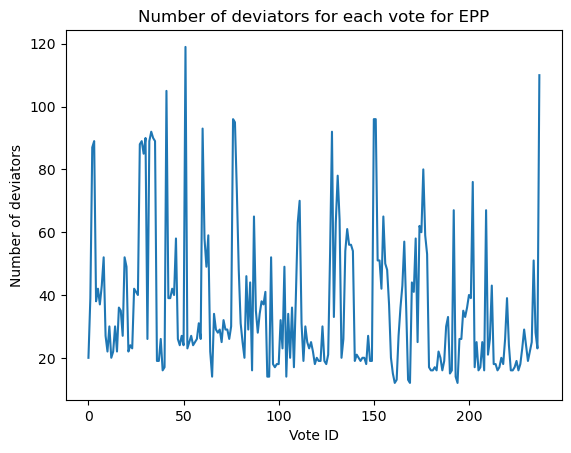

In [75]:
# count number of deviators for each vote for each party
deviator_counts = []
for dev in dev_masks:
    deviator_counts.append(dev.sum())
deviator_counts = np.array(deviator_counts)
print(f"Number of deviators for each vote for {PARTY}:")
print(deviator_counts)

# plot deviator counts for each vote
plt.plot(deviator_counts)
plt.title(f"Number of deviators for each vote for {PARTY}")
plt.xlabel("Vote ID")
plt.ylabel("Number of deviators")
plt.show()


In [76]:
# mean and std of deviator counts
print(f"Mean number of deviators per vote: {deviator_counts.mean()}")
print(f"Standard deviation of deviator counts: {deviator_counts.std()}")
# how many people does this party have in the EP?
print(f"Number of MEPs for {PARTY}: {len(mep_ids)}")


Mean number of deviators per vote: 36.411764705882355
Standard deviation of deviator counts: 22.613081573070726
Number of MEPs for EPP: 192


Number of deviators for each vote for EPP:
[ 20  39  87  89  38  42  37  43  52  27  22  30  20  22  30  22  36  35
  27  52  49  22  24  23  42  41  40  88  89  85  90  26  89  92  90  89
  19  19  26  16  17 105  39  39  42  40  58  26  24  27  24 119  23  25
  27  24  25  26  31  26  93  58  49  59  22  14  34  29  28  29  25  32
  29  29  26  30  96  95  73  48  31  25  20  46  29  44  16  65  35  28
  34  38  37  41  14  14  52  18  17  18  18  32  23  49  14  34  20  36
  17  39  63  70  31  19  30  25  23  25  22  18  20  19  19  30  19  18
  21  53  92  33  63  78  64  20  26  54  61  56  56  54  19  21  20  19
  20  20  18  27  19  19  96  96  51  51  42  65  50  48  37  20  15  12
  13  27  36  43  57  36  13  12  44  41  58  25  62  60  80  59  53  17
  16  16  17  16  22  20  16  19  30  33  15  16  67  14  12  26  26  35
  33  36  40  39  76  17  25  16  17  25  16  67  21  26  43  18  18  16
  17  20  18  26  39  24  16  16  17  19  16  18  23  29  24  19  22  25
  51  28

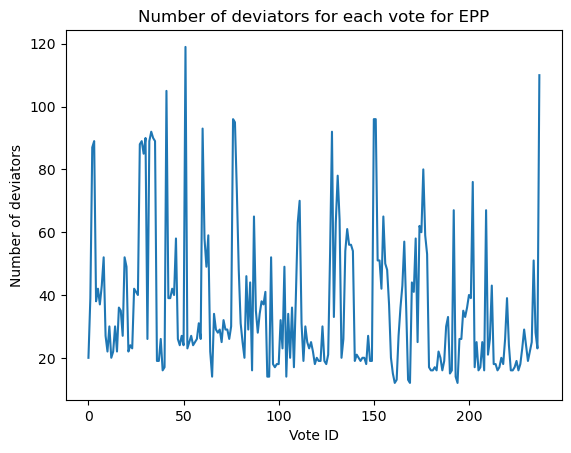

In [77]:
# count number of deviators for each vote for each party
deviator_counts = []
for dev in dev_masks:
    deviator_counts.append(dev.sum())
deviator_counts = np.array(deviator_counts)
print(f"Number of deviators for each vote for {PARTY}:")
print(deviator_counts)

# plot deviator counts for each vote
plt.plot(deviator_counts)
plt.title(f"Number of deviators for each vote for {PARTY}")
plt.xlabel("Vote ID")
plt.ylabel("Number of deviators")
plt.show()
